# Audio-text model for emotion classification
## Finetuned RuBert + HuBert
#### GitHub: GSKW

In [1]:
!pip install transformers

In [1]:
import transformers
import pandas as pd
import sklearn
import torch
import numpy as np
import torch
from transformers import AutoModelForSequenceClassification
from transformers import BertTokenizerFast
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, Dataset
import torchaudio
import torch
from typing import List
from transformers import get_linear_schedule_with_warmup
import time
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from transformers.optimization import Adafactor
import torch.nn as nn
from transformers import HubertForSequenceClassification, Wav2Vec2FeatureExtractor
import torchaudio
import torch
import torch.nn as nn

### Dusha dataset

In [2]:
# ! wget https://huggingface.co/datasets/KELONMYOSA/dusha_emotion_audio/resolve/main/data/train.tar.gz --no-check-certificate

In [3]:
# ! wget https://huggingface.co/datasets/KELONMYOSA/dusha_emotion_audio/resolve/main/data/test.tar.gz --no-check-certificate

In [4]:
# ! tar -xvzf train.tar.gz

In [5]:
# ! tar -xvzf test.tar.gz

### Models & tokenizers

In [6]:
device = 'cuda'

In [7]:
text_model = AutoModelForSequenceClassification.from_pretrained(
    'Aniemore/rubert-tiny2-russian-emotion-detection',
    output_hidden_states=True,
    ignore_mismatched_sizes=True
    ).to(device)



In [8]:
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/hubert-base-ls960")
tokenizer = BertTokenizerFast.from_pretrained('Aniemore/rubert-tiny2-russian-emotion-detection')

In [9]:
audio_model = HubertForSequenceClassification.from_pretrained("xbgoose/hubert-base-speech-emotion-recognition-russian-dusha-finetuned", 
                                                              output_hidden_states=True).to(device)
num2emotion = {0: 'neutral', 1: 'angry', 2: 'positive', 3: 'sad', 4: 'other'}

### Dataset & collate classes

In [10]:
def pad_tensor(vec, pad, dim):
    """
    args:
        vec - tensor to pad
        pad - the size to pad to
        dim - dimension to pad

    return:
        a new tensor padded to 'pad' in dimension 'dim'
    """
    pad_size = list(vec.shape)
    pad_size[dim] = pad - vec.size(dim)
    return torch.cat([vec, torch.zeros(*pad_size)], dim=dim)

class PadCollate:
    """
    a variant of callate_fn that pads according to the longest sequence in
    a batch of sequences
    """

    def __init__(self, dim=0):
        """
        args:
            dim - the dimension to be padded (dimension of time in sequences)
        """
        self.dim = dim

    def pad_collate(self, batch):
        """
        args:
            batch - list of (tensor, label)

        reutrn:
            xs - a tensor of all examples in 'batch' after padding
            ys - a LongTensor of all labels in batch
        """
        # find longest sequence
        max_len = max(map(lambda x: x[0].shape[self.dim], batch))
        # pad
        data = [pad_tensor(x[0], pad=max_len, dim=self.dim) for x in batch]
        # stack all
        xs = torch.stack(data, dim=0)
        ys = torch.LongTensor([y[1] for y in batch])
        return xs, ys

    def __call__(self, batch):
        return self.pad_collate(batch)

collator = PadCollate(dim=1)

In [11]:
def get_input(filepath):
        waveform, sample_rate = torchaudio.load(filepath, normalize=True)
        transform = torchaudio.transforms.Resample(sample_rate, 16000)
        waveform = transform(waveform)

        inputs = feature_extractor(
                waveform,
                sampling_rate=feature_extractor.sampling_rate,
                return_tensors="pt",
                padding=True,
                max_length=16000 * 10,
                truncation=True

        )
        return inputs['input_values'][0]

In [12]:
class AudioDataset(Dataset):
    def __init__(self, dataframe):
        self.paths = dataframe['file']
        self.tensors = [get_input(x) for x in tqdm(self.paths)]
        self.labels = dataframe['label'].values
        self.frame = dataframe
        self.emotion2label = {
            "neutral":0,
            "positive":1,
            "sad":2,
            "angry":3,
            "other":4
        }
    def __len__(self):
        return len(self.frame)
    def __getitem__(self, idx):
        return self.tensors[idx], torch.tensor(self.emotion2label[self.labels[idx]])


In [13]:
class TextDataset(Dataset):
    def __init__(self, dataframe):
        # self.n = 0.8
        self.data = dataframe

        # size = int(len(dataframe)*self.n)
        # if shuffle:
        #     mask = torch.randperm(len(dataframe))
        #     self.data = self.data.iloc[mask]
        # if train:
        #     self.data = self.data[:size]
        # else:
        #     self.data = self.data[size:]

        self.emotion2label = {
            "neutral":0,
            "positive":1,
            "sad":2,
            "angry":3,
            "other":4
        }
        self.texts = self.data['predicted_text'].values
        self.labels = self.data['label'].values
        self.tokens = [self.tokenize_function(x) for x in tqdm(self.texts)]

    def tokenize_function(self, text):
        return tokenizer(text, max_length=512, padding='max_length', return_tensors='pt')

    def __len__(self):
        return len(self.tokens)

    def __getitem__(self, idx):
        # print(self.tokenize_function(self.data['predicted_text'][idx]))
        # print(self.texts[idx])
        tokenized = self.tokens[idx]
        return torch.cat([tokenized['input_ids'],
                          tokenized['token_type_ids'],
                          tokenized['attention_mask']], 0), torch.tensor(self.emotion2label[self.labels[idx]])

### Reading data

In [15]:
train_dataset_dataframe = pd.read_csv('train_dataset.csv')
train_text_frame = pd.read_csv('train_with_text.csv')
train_text_frame.rename(columns = {'audio_path':'file'}, inplace=True)
train_text_frame.drop(columns=['Unnamed: 0'], inplace=True)
train_dataset_dataframe.rename(columns = {'audio_path':'file'}, inplace=True)
train_frame = train_text_frame.merge(train_dataset_dataframe, how='left', on='file')

classes = train_frame['label'].unique()

arr = []
for class_ in classes:
    arr.append(train_frame.loc[train_frame['label'] == class_][:10000])
arr.extend([train_frame.loc[train_frame['label'] == class_]]*10)

train_frame = pd.concat(arr)

In [16]:
mask = torch.randperm(len(train_frame))
train_frame = train_frame.iloc[mask]

### Dataset with preprocessing & dataloaders

In [17]:
torch.set_num_threads(1)

In [22]:
test_dataset_audio = AudioDataset(train_frame)
test_dataset_text = TextDataset(train_frame)

  0%|          | 0/43619 [00:00<?, ?it/s]

In [23]:
bs = 4
audio_loader = DataLoader(
    test_dataset_audio,
    collate_fn=collator,
    batch_size=bs
)
text_loader = DataLoader(
    test_dataset_text,
    collate_fn=collator,
    batch_size=bs
)

## Net

In [126]:
class Net(nn.Module):
    def __init__(self, text_model, audio_model):
        super(Net, self).__init__()
        self.text_model = text_model
        self.audio_model = audio_model

        self.classifier = nn.Sequential(
            # nn.Dropout(p=0.1),
            nn.Linear(1280, 1280, bias=True),
            nn.LeakyReLU(),
            nn.Linear(1280, 1280, bias=True),
            nn.LeakyReLU(),
            nn.Linear(1280, 512, bias=True),
            nn.LeakyReLU(),
            # nn.Dropout(p=0.2),
            nn.Linear(512, 256, bias=True),
            nn.LeakyReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(256, 64, bias=True),
            nn.LeakyReLU(),
            # nn.Dropout(p=0.2),
            nn.Linear(64, 5, bias=True)
        )

        # Text labels to int
        self.emotion2label = {
            "neutral":0,
            "positive":1,
            "sad":2,
            "angry":3,
            "other":4
        }


    def tokenize_function(self, text: str) -> torch.tensor:
        tokenized = tokenizer(text, max_length=512, padding='max_length', return_tensors='pt')
        return torch.cat([tokenized['input_ids'],
                          tokenized['token_type_ids'],
                          tokenized['attention_mask']], 0)

    def get_input(self, filepath: str) -> torch.tensor:
        waveform, sample_rate = torchaudio.load(filepath, normalize=True)
        transform = torchaudio.transforms.Resample(sample_rate, 16000)
        waveform = transform(waveform)

        inputs = feature_extractor(
                waveform,
                sampling_rate=feature_extractor.sampling_rate,
                return_tensors="pt",
                padding=True,
                max_length=16000 * 10,
                truncation=True

        )
        return inputs['input_values'][0]

    def forward(self, text_data, inputs):
        b_input_ids, b_type_ids, b_input_mask,  = text_data[:, 0, :], text_data[:, 1, :], text_data[:, 2, :]

        # Output from text model
        logits_a = self.text_model(
                       b_input_ids.to(device).long(),
                       b_input_mask.to(device),
                       b_type_ids.to(device).long(),
                       output_hidden_states=True
                      )['hidden_states'][-1][:,:,-1]

        # Output from audio model
        logits_b = self.audio_model(inputs.to(device))['hidden_states'][-1][:,-1,:]
        concatenated_vectors = torch.cat([logits_a.to(device), logits_b.to(device)], 1)
        output = self.classifier(concatenated_vectors)

        # Delete rubbish from memory
        del concatenated_vectors, logits_a, logits_b, text_data, inputs
        torch.cuda.empty_cache()
        
        return output

In [15]:
model = Net(text_model, audio_model)
model.to(device)
model = model.train()

for name, param in model.named_parameters():
    param.requires_grad = True

Net(
  (text_model): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(83828, 312, padding_idx=0)
        (position_embeddings): Embedding(2048, 312)
        (token_type_embeddings): Embedding(2, 312)
        (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-2): 3 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=312, out_features=312, bias=True)
                (key): Linear(in_features=312, out_features=312, bias=True)
                (value): Linear(in_features=312, out_features=312, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=312, out_features=312, bias=T

In [16]:
label2emotion = {
    0: "neutral",
    1: "positive",
    2: "sad",
    3: "angry",
    4: "other"
}
emotion2label = {
    "neutral":0,
    "positive":1,
    "sad":2,
    "angry":3,
    "other":4
        }

In [17]:
from sklearn.metrics import accuracy_score

In [18]:
def get_acc(test_audio_loader, test_text_loader):
    model.eval()
    true_labels = []
    pred_labels = []
    
    for audio, text_label in tqdm(zip(test_audio_loader, test_text_loader), total=len(dataset_dataframe), colour='MAGENTA'):
        text, label = text_label
        output = model(text.to(device), torch.squeeze(audio[0], dim=1).to(device))
        pred_labels.append(int(torch.argmax(output).cpu()))
        true_labels.append(int(label.cpu().detach()))
    return accuracy_score(true_labels, pred_labels)

In [19]:
dataset_dataframe = pd.read_csv('test.csv')
dataset_dataframe.columns = ['file', 'label']
dataset_dataframe['emotion'] = dataset_dataframe['label'].replace(label2emotion)
text_frame = pd.read_csv('test_with_text.csv')
text_frame.rename(columns={'audio_path':'file'}, inplace=True)
text_frame.drop(columns=['Unnamed: 0'], inplace=True)
dataset_dataframe = dataset_dataframe.merge(text_frame, how='left', on='file').drop(columns=['emotion'])
dataset_dataframe['predicted_text'].fillna(' ', inplace=True)

classes = [x for x in dataset_dataframe['label'].unique() if x != 'other']
arr = []
for class_ in classes:
    arr.append(dataset_dataframe.loc[dataset_dataframe['label'] == class_][:2400])
dataset_dataframe = pd.concat(arr)
mask = torch.randperm(len(dataset_dataframe))
dataset_dataframe = dataset_dataframe.iloc[mask]

In [20]:
test_t_dataset_audio = AudioDataset(dataset_dataframe)
test_t_dataset_text = TextDataset(dataset_dataframe)

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

In [21]:
t_bs = 1
test_audio_loader = DataLoader(
    test_t_dataset_audio,
    collate_fn=collator,
    batch_size=t_bs
)
test_text_loader = DataLoader(
    test_t_dataset_text,
    collate_fn=collator,
    batch_size=t_bs
)

In [68]:
optimizer = AdamW(model.parameters(), lr=5e-6)
loss = nn.CrossEntropyLoss()

In [69]:
n_epochs = 5

In [70]:
scheduler = transformers.get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=n_epochs*int(len(train_frame)/bs))

In [71]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [72]:
count_parameters(model)

127849153

In [73]:
# model = torch.load('model_7_epoch.pth')

In [74]:
# get_acc(test_audio_loader, test_text_loader)

In [25]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

In [27]:
model.eval()
true_labels = []
pred_labels = []

for audio, text_label in tqdm(zip(test_audio_loader, test_text_loader), total=len(dataset_dataframe), colour='MAGENTA'):
    text, label = text_label
    output = model(text.to(device), torch.squeeze(audio[0], dim=1).to(device))
    pred_labels.append(int(torch.argmax(output).cpu()))
    true_labels.append(int(label.cpu().detach()))

  0%|          | 0/9600 [00:00<?, ?it/s]

In [23]:
model.eval()
true_labels_prob = []
pred_labels_prob = []

for audio, text_label in tqdm(zip(test_audio_loader, test_text_loader), total=len(dataset_dataframe), colour='MAGENTA'):
    text, label = text_label
    output = model(text.to(device), torch.squeeze(audio[0], dim=1).to(device))
    pred_labels_prob.append(output.cpu().detach())
    true_labels_prob.append(int(label.cpu().detach()))

  0%|          | 0/9600 [00:00<?, ?it/s]

In [27]:
f1_score(true_labels, pred_labels, average='weighted')

NameError: name 'true_labels' is not defined

In [33]:
pred_labels_prob = torch.cat(pred_labels_prob, 0)

In [40]:
proba = torch.softmax(pred_labels_prob, 1)

In [47]:
roc_auc_score(true_labels_prob, proba, average='weighted', multi_class='ovo', labels=[0,1,2,3,4])

0.9676261067708335

In [55]:
pred = torch.argmax(proba, 1)

In [58]:
accuracy_score(pred, true_labels_prob)

0.870625

In [78]:
# del text_model

In [79]:
# del audio_model

In [80]:
loss_array = []

In [81]:
model.train()
None

In [ ]:
i = 0

accuracy = 0.0
for epoch in range(n_epochs):
    pbar = tqdm(total = int(len(train_frame)/bs))
    n = 0
    for audio, text_label in zip(audio_loader, text_loader):
        optimizer.zero_grad()
        text, label = text_label
        # print(text_label[0].shape)
        output = model(text.to(device), torch.squeeze(audio[0], dim=1).to(device))
        # print(label.shape)
        # print(output)
        # print(output.shape, label.shape)
        # print(torch.argmax(output).shape)
        loss_ = loss(output, label.to(device))
        # loss_array.append(loss_.detach().cpu())
        
        if i % 50 == 0:
            # print(n/50)
            loss_array.append(n/50)
            pbar.set_postfix(
                {
                    'loss': str(n/50)[:8],
                    'epoch': epoch+1,
                    'acc': accuracy
                }
            )
            n = 0
        n += float(loss_.cpu().detach())
        
        loss_.backward()
        optimizer.step()
        scheduler.step()
        del output, audio, text_label, text, label
        torch.cuda.empty_cache()
        i += 1
        pbar.update()
    
    accuracy = get_acc(test_audio_loader, test_text_loader)
    pbar.set_postfix(
                {
                    'loss': str(n/50)[:8],
                    'epoch': epoch+1,
                    'acc': accuracy
                }
            )
    torch.save(model, f'new_model_{epoch+1}_epoch_{accuracy}.pth')
    print(epoch, accuracy)
    model.train()

  0%|          | 0/10904 [00:00<?, ?it/s]

In [1]:
model = torch.load('model_7_epoch.pth')

NameError: name 'torch' is not defined

In [48]:
torch.save(model, 'model.pth')

In [46]:
for g in optimizer.param_groups:
    print(g['lr'])

5e-07


In [44]:
dataset_dataframe.loc[dataset_dataframe['label'] == 'positive']

,file,label,predicted_text
5863,test/7247406c79ba0acc43dd53bcd789613a.wav,positive,салют сбер спасибо
13274,test/dfba46efade7cc9840535afe91c525be.wav,positive,спасибо огромная ты очень умная девочка
4956,test/9eda00108d696d4ae173dd75f3384b12.wav,positive,знаешь что у меня есть братик у тебя есть како...
12040,test/60838540bd19d2bd3b6d6d225bc68af2.wav,positive,как дела у меня падалка
17787,test/60f891d8aa09c87848d05fc6b25fb748.wav,positive,мне тоже очень приятно как у тебя дела
...,...,...,...
11458,test/6981eabaf9b929934cfd5c208e0731bf.wav,positive,здравствуйте всегда радуюсь когда слышу вас
19383,test/0a6dd97957b9f808aeb5674ad617cf98.wav,positive,было прикольно
11672,test/41e5319cb8228fc4b2a1d2f796d68e2c.wav,positive,испанские морские владения
22588,test/d11a1b6d6a278973f70f7f5ad026065b.wav,positive,лайк подписываюсь


In [51]:
pred_labels = []

In [96]:
net = torch.load('model.pth')

In [21]:
net = HubertForSequenceClassification.from_pretrained("xbgoose/hubert-base-speech-emotion-recognition-russian-dusha-finetuned", 
                                                      output_hidden_states=True
                                                     ).to(device)

In [35]:
label2emotion = {
    0: "neutral",
    1: "positive",
    2: "sad",
    3: "angry",
    4: "other"
}
model2data = {
    0:0,
    1:3,
    2:1,
    3:2,
    4:4
}

In [37]:
net.eval()
true_labels1 = []
pred_labels1 = []

for audio, text_label in tqdm(zip(test_audio_loader, test_text_loader), total=len(dataset_dataframe), colour='MAGENTA'):
    text, label = text_label
    output = net(torch.squeeze(audio[0], 0).to(device)).logits
    # print(output)
    pred_labels1.append(model2data[int(torch.argmax(output).cpu())])
    true_labels1.append(int(label.cpu()))
    # print(model2data[int(torch.argmax(output).cpu())], int(label.cpu()))

print(accuracy_score(true_labels1, pred_labels1))

  0%|          | 0/9600 [00:00<?, ?it/s]

0.871875


In [33]:
print(accuracy_score(true_labels1, pred_labels1))

0.8552083333333333


In [64]:
model.

__main__.Net

In [71]:
for audio in tqdm(test_audio_loader, total=len(dataset_dataframe), colour='MAGENTA'):
    text, label = text_label
    output = model(text.to(device), torch.squeeze(audio[0], dim=1).to(device))
    pred_labels1.append(int(torch.argmax(output).cpu()))
    true_labels1.append(int(label.cpu()))

In [73]:
# dataset_dataframe = dataset_dataframe.iloc[:10000]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

In [38]:
del audio_loader

In [39]:
del text_loader

In [78]:
import gc

In [79]:
gc.collect()

36

In [69]:
torch.save(model, 'test_model.ppt')

In [81]:
import gc
gc.collect()

0

In [83]:
from sklearn.metrics import classification_report

In [70]:
net = torch.load('test_model.ppt')

In [71]:
net.eval()
None

Net(
  (text_model): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(83828, 312, padding_idx=0)
        (position_embeddings): Embedding(2048, 312)
        (token_type_embeddings): Embedding(2, 312)
        (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-2): 3 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=312, out_features=312, bias=True)
                (key): Linear(in_features=312, out_features=312, bias=True)
                (value): Linear(in_features=312, out_features=312, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=312, out_features=312, bias=T

In [80]:
print(accuracy_score([1,1,1,1,0,0,1], [1,0,1,0,1,0,1]))

0.5714285714285714


In [59]:
import matplotlib.pyplot as plt

In [60]:
from sklearn.metrics import confusion_matrix

In [61]:
matrix = confusion_matrix(true_labels_prob, pred)

In [68]:
matrix

array([[2074,   84,  138,   99,    5],
       [ 235, 2049,   16,   96,    4],
       [ 300,   11, 2033,   27,   29],
       [ 114,   58,   17, 2202,    9],
       [   0,    0,    0,    0,    0]])

In [69]:
n_matrix = matrix[:-1, :-1]

In [62]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

In [121]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(7, 7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig('test.pdf')
    plt.show()
    

In [122]:
# num2emotion = {0: 'neutral', 1: 'angry', 2: 'positive', 3: 'sad', 4: 'other'}

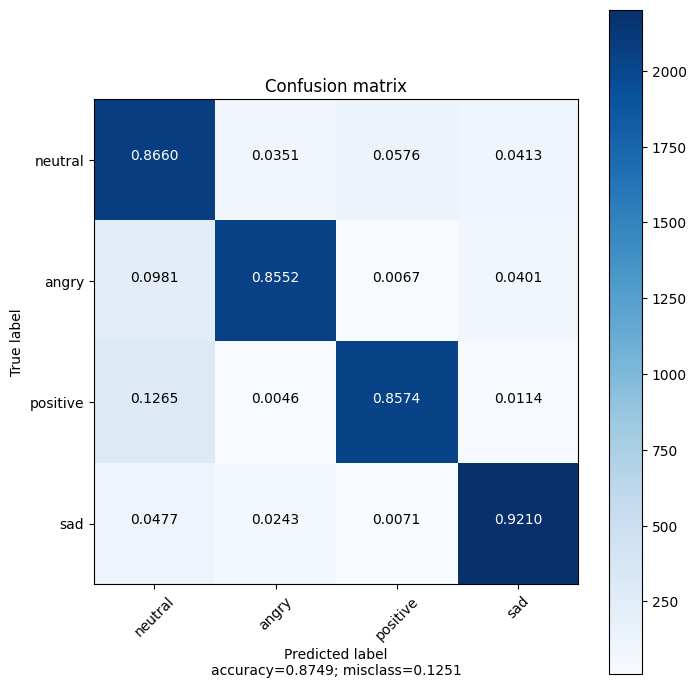

In [123]:
plot_confusion_matrix(n_matrix, ['neutral','angry', 'positive', 'sad'])